# Improving Below Ground Salt Identification

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tensorflow as tf

from skimage.transform import resize


from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.preprocessing.image import load_img

from sklearn.model_selection import train_test_split

import cv2
import sklearn.preprocessing

# import warnings
# warnings.filterwarnings("ignore")

First, we need to specifiy the file paths to our data:

In [74]:
path_test_images =  './test/images/' # Directory containing the test images
path_train_images = './train/images/' # Directory containing the training images
path_train_masks = './train/masks/' # Directory containing the training masks

Load the raw data csv files and clean them up a bit:

In [75]:
# 'Depths.csv' contains all of the image ids - train and test -  along with the depth where the image was taken 
depth_data = pd.read_csv('depths.csv', index_col='id')
depth_data.columns = ['depth'] # Rename the column 'z' to 'depth' so its easier to understand

# 'train.csv' contains all of the image ids in the training set
# It also contains another column called 'rle_mask' which isn't very useful, so we convert it to a new variable to indicate if there is salt in the image
train_data = pd.read_csv('train.csv', index_col='id')
train_data['contains_salt'] = ~train_data['rle_mask'].isna()
train_data.drop(columns='rle_mask',inplace=True)

# Merge all of the info together so that we now have training and test data frames
train_df = train_data.merge(depth_data,left_index=True, right_index=True)
test_df = depth_data[~depth_data.index.isin(train_df.index)]

train_df.head()

,contains_salt,depth
id,,
2c45b152f1,True,312
3cb59a4fdc,True,603
e185ab5dc1,True,687
c78c89577c,True,236
6306dd3a8e,True,805


We create some helper functions for working with the images:

In [76]:
def get_img_by_id(id:str, as_array:bool=True):
    """Returns a 101 x 101 numpy array of the image by default. If 'as_array' = False then it will return an image pillow object"""
    if id in train_df.index:
        img =  load_img(path_train_images + id + '.png')
    elif id in test_df.index:
        img = load_img(path_test_images + id +  '.png')
    else:
        raise Exception(f'"{id}" is not a valid id you goon!!!')

    if as_array:
        # Return the image as a 3d array with one channel. We don't need the 2&3 channels because this is a grayscale image and they are identical
        return np.array(img)[:,:,:1]
    else:
        return img


def get_mask_by_id(id:str, as_array:bool=True):
    """Same as above, just with the masks of training images"""
    img = load_img(path_train_masks + id + '.png')
    if as_array:
        # Return the image as a 2d array. We don't need the 2&3 channels because this is a grayscale image and they are identical
        return np.array(img)[:,:,:1]
    else:
        return img

Now we can visualize a few examples from the training set. Below is displayed several example seismic images, with their accompanying salt idenfitification masks placed adjacent. 

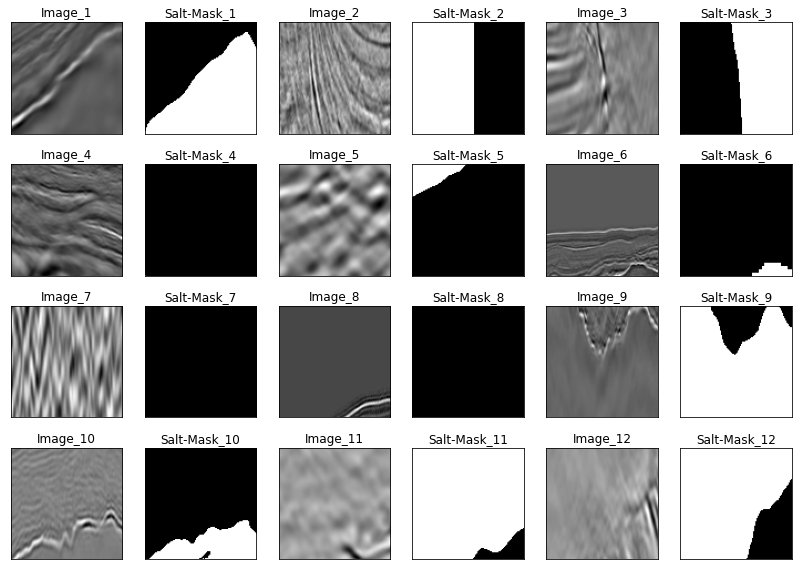

In [77]:
imgs_to_show = 12 # Needs to be a multiple of 6
num_cols = 6
num_rows = int(imgs_to_show/num_cols * 2)

sample_training_ids = train_df.index[:imgs_to_show]
# Uncomment out the below line if you'd like to show a random 12 images each time, instead of the first 12
# sample_training_ids = np.random.choice(train_df.index,imgs_to_show)

plt.figure(figsize=(14, 10))
for i in range(0,imgs_to_show):
    ax = plt.subplot(num_rows, num_cols, (i + 1)*2-1)
    ax.imshow(get_img_by_id(sample_training_ids[i]),cmap='gray')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.title.set_text(f'Image_{i+1}')
  
    ax = plt.subplot(num_rows, num_cols, (i + 1)*2)
    ax.imshow(get_mask_by_id(sample_training_ids[i]),cmap='gray')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.title.set_text(f'Salt-Mask_{i+1}')

# plt.suptitle('Sample Images & Masks', fontsize=15);

## Prepare Data for Model

In [78]:
# We need to resize the images to 128x128 to be compatible with U-Net framework
img_size_needed = 128

Load in all of the images and their masks as numpy arrays:

In [79]:
X_all = np.array([get_img_by_id(id) for id in train_df.index])
Y_all = np.array([get_mask_by_id(id) for id in train_df.index])

Now, resize all the images. The cell below is messy but it's vectorized for performance purposes.

In [80]:
X_all_resized = np.array([np.floor(resize(img, (img_size_needed, img_size_needed, 1), mode='constant', preserve_range=True)) for img in X_all])
Y_all_resized = np.array([np.array(resize(img, (img_size_needed, img_size_needed, 1), mode='constant', preserve_range=True),dtype=bool) for img in Y_all])

Now that everything is resized, we'll split it into training and validation sets.

In [81]:
X_train_og, X_test, Y_train_og, Y_test  = train_test_split(X_all_resized, Y_all_resized,train_size=3500, random_state=42)

Now we carry out the data augmentation by adding in some extra training images. The new images are created by left-right flipping, yp-down flipping, and 90 degree rotations. Afterwards, we shuffle the data set just to make sure we didn't introduce any weird correlations between model inputs.

In [82]:
X_ud_flipped = [np.flipud(img) for img in X_train_og]
X_lr_flipped = [np.fliplr(img) for img in X_train_og]
X_rotated = [np.rot90(img) for img in X_train_og]

Y_ud_flipped = [np.flipud(img) for img in Y_train_og]
Y_lr_flipped = [np.fliplr(img) for img in Y_train_og]
Y_rotated = [np.rot90(img) for img in Y_train_og]

X_train = np.concatenate([X_train_og,X_ud_flipped,X_lr_flipped,X_rotated])
Y_train = np.concatenate([X_train_og, Y_ud_flipped, Y_lr_flipped,Y_rotated])

# Shuffle, just to make sure we didn't accidently introduce anything weird.
shuffled_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

We validate that our augmentations worked correctly by plotting a few test images below:

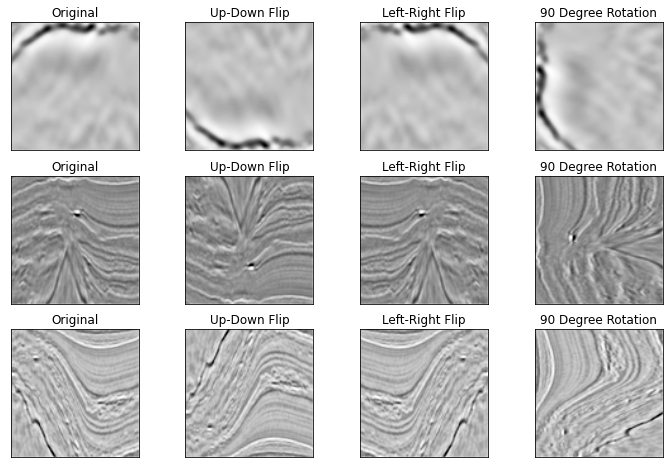

In [83]:
imgs_to_show = 3 # Needs to be a multiple of 6

plt.figure(figsize=(12, 8))
im_start = 15
for i in range(0,imgs_to_show):
    im_index = i +im_start
    ax = plt.subplot(imgs_to_show, 4, (i)*4+1)
    ax.imshow(X_train_og[im_index],cmap='Greys')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.title.set_text(f'Original')

    ax = plt.subplot(imgs_to_show, 4, (i)*4+2)
    ax.imshow(X_ud_flipped[im_index],cmap='Greys')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.title.set_text(f'Up-Down Flip')

    ax = plt.subplot(imgs_to_show, 4, (i)*4+3)
    ax.imshow(X_lr_flipped[im_index],cmap='Greys')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.title.set_text(f'Left-Right Flip')

    ax = plt.subplot(imgs_to_show, 4, (i)*4+4)
    ax.imshow(X_rotated[im_index],cmap='Greys')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.title.set_text(f'90 Degree Rotation')

## Model Building

Prior to the model training, there are a few parameters that need to be set.

In [84]:
# This let's us specificy the input to the model
IMG_WIDTH, IMG_HEIGHT = 128, 128

# Define IoU metric
def mean_iou(y_true, y_pred):
    """Evaluation metric."""
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### Sobel Filter

The below cell is only needed if you would like to try out the Sobel Filter. It did not work too well, so we've commented it out, but kept the procedure here for reference. Keep in mind, to implement it in the model below, you will also need to change the models input to accept 2 channels.

In [85]:

# sobelxy = []
# i=0
# for img in X_train:
#     sobel_out = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
#     sobel_norm = sklearn.preprocessing.normalize(sobel_out)
#     sobelxy.append((sobel_norm + 1)/2)
#     i+=1

# X_train_sobel = np.array(sobelxy).reshape(14000, 128, 128, 1)
# X_train_channel = np.concatenate((X_train,X_train_sobel), axis =3)
# X_train_channel.shape


# sobelxy_test = []
# i=0
# for img in X_test:
#     sobel_out = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
#     sobel_norm = sklearn.preprocessing.normalize(sobel_out)
#     sobelxy_test.append((sobel_norm + 1)/2)
#     i+=1
# X_test_sobel = np.array(sobelxy_test).reshape(500, 128, 128, 1)
# X_test_channel = np.concatenate((X_test,X_test_sobel), axis=3)

On to building the U-Net with Keras! The Keras functional API is pretty intuitive and easy to use. The ouput of each function is another function, which allows you to pass the new layer as an input to the current layer. All we need to do is use the image as our blue print and follow along!

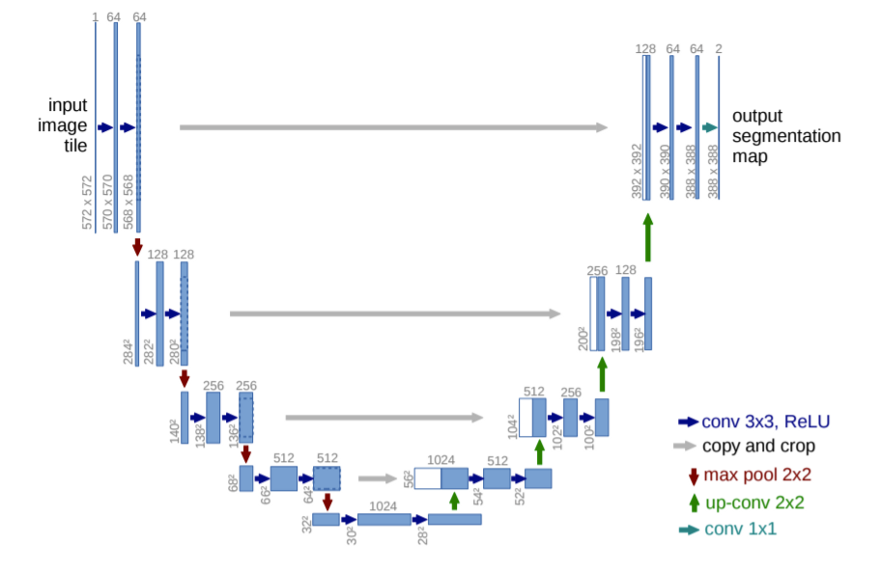

In [86]:
# Number of inputs equals the number of pixels in our images * number of channels, which in this case is 1 because the images are greyscale.

inputs = Input((IMG_WIDTH, IMG_HEIGHT, 1))
 
# Layer to convert the pixels to 0-1 scales which is expected from later on layers
s = Lambda(lambda img_pixels: img_pixels / 255) (inputs)


c1 = Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same') (s)
c1 = Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(filters = 16, kernel_size=(3,3), activation='relu', padding='same') (p1)
c2 = Conv2D(filters = 16, kernel_size=(3,3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D(pool_size=(2, 2)) (c2)

c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same') (p2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D(pool_size=(2, 2)) (c3)

c4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same') (p3)
c4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same') (p4)
c5 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same') (u6)
c6 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same') (u7)
c7 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(filters=16, kernel_size=(2,2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same') (u8)
c8 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(filters=8, kernel_size=(2,2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same') (u9)
c9 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same') (c9)

# Final output is sigmoid so that we get a probability for each pixel!
outputs = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid') (c9)

unet_model = Model(inputs=[inputs], outputs=[outputs])
# unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou, 'accuracy'])
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
# unet_model.summary()

And away we go!!

In [90]:
epochs = 30
batch_size = 10 # Use 10 images in each batch

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('salty_unet_model_contrasted_channel.h5', verbose=1, save_best_only=True)
results = unet_model.fit(X_train, Y_train,validation_data = (X_test,Y_test) ,batch_size=batch_size, epochs=epochs, 
                         callbacks=[earlystopper, checkpointer])

### Training Results

In [ ]:
history_df = pd.DataFrame(results.history)
history_df

,val_loss,val_mean_iou,val_accuracy,loss,mean_iou,accuracy
0,0.376734,0.417120,0.865077,0.484171,0.389057,0.791539
1,0.322655,0.495357,0.883197,0.364716,0.457651,0.863246
2,0.315717,0.544154,0.889548,0.326264,0.521298,0.882467
3,0.259178,0.580545,0.908071,0.292005,0.562282,0.896486
4,0.237355,0.606651,0.917576,0.272754,0.593105,0.903424
5,0.242163,0.629586,0.917378,0.240318,0.618724,0.915095
6,0.238131,0.646914,0.913611,0.231207,0.639171,0.917413
7,0.229745,0.661908,0.910486,0.214374,0.654563,0.922767
8,0.206481,0.674956,0.922319,0.203178,0.668907,0.927117
9,0.208295,0.685992,0.926043,0.195502,0.680914,0.929645


In [ ]:
history_df['epoch'] = history_df.index

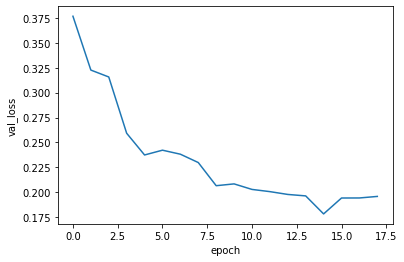

In [ ]:
import seaborn as sns

sns.lineplot(data = history_df, x='epoch', y = 'val_loss')

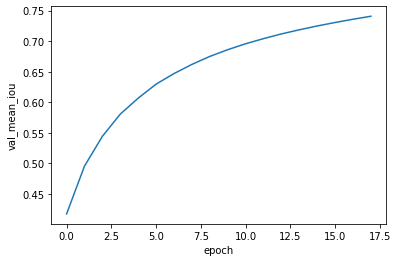

In [ ]:
sns.lineplot(data = history_df, x='epoch', y = 'val_mean_iou')

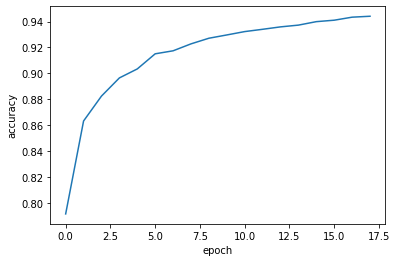

In [ ]:
sns.lineplot(data = history_df, x='epoch', y = 'accuracy')

## Predictions

Now we can load the model without having to retrain it!!!

In [ ]:
# Load Model
unet_model = load_model('salty_unet_model_contrasted_channel.h5')

prob_threshold = .5

Predict on train, val, and test

In [ ]:
# Predict on train, val and test

# preds_train = unet_model.predict(X_train, verbose=1)
preds_val = unet_model.predict(X_train, verbose=1)
# preds_test = unet_model.predict(X_test, verbose=1)

# Threshold predictions
# preds_train_t = (preds_train > prob_threshold).astype(np.uint8)
preds_val_t = (preds_val > prob_threshold).astype(np.uint8)
# preds_test_t = (preds_test > prob_threshold).astype(np.uint8)

16/16 [==============================] - 3s 173ms/step


Let's examine some predictions!

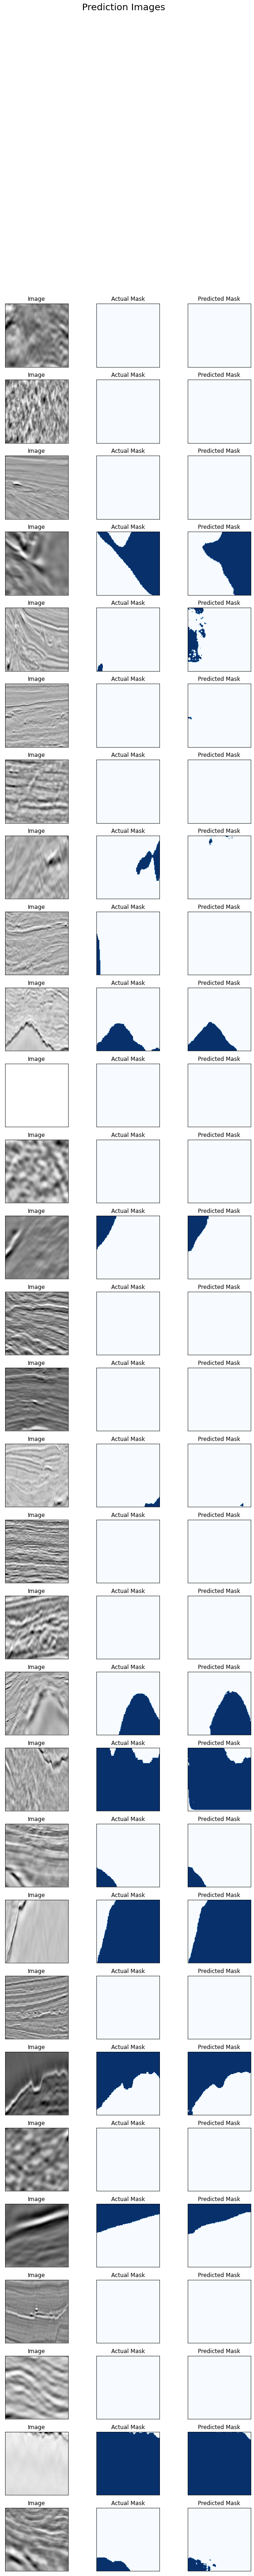

In [ ]:
imgs_to_show = 30
num_rows = imgs_to_show; num_cols = 3

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols,  figsize=(10, 3*imgs_to_show))

for i in range(imgs_to_show):
    ax = axs[i,0]
    ax.imshow(X_test[i],cmap='Greys')
    ax.title.set_text(f'Image')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    ax = axs[i,1]
    ax.imshow(Y_test[i],cmap='Greys')
    ax.title.set_text(f'Actual Mask')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    ax = axs[i,2]
    ax.imshow(preds_val_t[i],cmap='Greys')
    ax.title.set_text(f'Predicted Mask')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


plt.suptitle('Prediction Images',fontsize=20);